# 1. Setup and Imports

This section sets up the environment and necessary libraries for accessing and processing ECMWF Open Data.

In [1]:
from datetime import datetime, timedelta
import earthkit.data as ekd
import matplotlib.pyplot as plt

# Create data directory if not present
import os
os.makedirs("data", exist_ok=True)

### Determine latest model run

We use 12z if available (after 12:00 UTC), otherwise 00z from today or yesterday. This is important because the ECMWF Open Data archive only retains recent data (typically the past 3–5 days).

In [2]:
now = datetime.utcnow()
if now.hour >= 12:
    model_run_hour = 12
    model_run_date = now
else:
    model_run_hour = 0
    model_run_date = now - timedelta(days=1)

fc_date = model_run_date.strftime("%Y%m%d")
fc_time = f"{model_run_hour:02}"
print(f"Using model run: {fc_date} at {fc_time}z")

Using model run: 20250808 at 12z



# ECMWF Open Data – Advanced Tutorial

This tutorial demonstrates how to retrieve and visualize data from ECMWF’s Open Data service using [EarthKit](https://earthkit.readthedocs.io/) and [ecmwf-opendata](https://github.com/ecmwf/ecmwf-opendata).

We will cover:
1. Data retrieval from all 4 supported models (HRES, ENS, AIFS, AIFS-ENS)
2. Visualization of retrieved parameters
3. EarthKit plotting capabilities
4. Derived calculations
5. Data reformatting (GeoTIFF, etc.)


In [3]:
import os
import earthkit.data as ekd
import earthkit.plots as ekp
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime


## 2. Accessing ECMWF Open Data

We demonstrate retrieval of 4 model types:

- **HRES**: High-resolution deterministic model
- **ENS**: Ensemble prediction system (51 members)
- **AIFS**: AI-based deterministic model
- **AIFS-ENS**: AI-based ensemble

Each dataset is downloaded dynamically using `earthkit.data`.


### 2.1 Where is the data coming from?

ECMWF's open forecast data is hosted publicly at:

https://data.ecmwf.int/

No authentication or API key is needed.

EarthKit (`earthkit.data`) and the `ecmwf-opendata` Python client both retrieve forecast GRIB files by constructing URLs from this site.

## Directory structure

The URL structure follows this format:

https://data.ecmwf.int/forecasts/YYYYMMDD/HHz/{model}/{resolution}/{stream}/

- `YYYYMMDD` → Forecast date
- `HHz` → Model run time (00z or 12z)
- `model`:
  - `ifs` → Traditional IFS forecasts (HRES, ENS)
  - `aifs-single` → AI deterministic
  - `aifs-ens` → AI ensemble
- `resolution`:  
  - `0p25`, `0p5`, or `1p0`
- `stream`:  
  - `oper` → HRES / AIFS  
  - `enfo` → ENS / AIFS-ENS  
  - `waef`, `wave` → Wave forecasts

## Supported forecast models

| Model ID | Description              | Example Path                                      |
|----------|--------------------------|---------------------------------------------------|
| `ifs`    | HRES and ENS             | `/ifs/0p25/oper/`, `/ifs/0p5/enfo/`               |
| `aifs-single` | AI deterministic       | `/aifs-single/0p25/oper/`                         |
| `aifs-ens` | AI ensemble              | `/aifs-ens/0p25/enfo/`                            |
| `ifs/wave` | Wave deterministic       | `/ifs/0p25/wave/`                                 |
| `ifs/waef` | Wave ensemble            | `/ifs/0p25/waef/`                                 |

---

EarthKit and the `ecmwf-opendata` client automatically construct these URLs — but sometimes custom tuning is needed (e.g. using `"ifs"` with `model="ens"` and `stream="enfo"`).

In this notebook, we will explore:
- How to access and validate those GRIB files
- How to interpret the structure
- How to find available parameters for each model



### 2.2 Understanding Keywords and API Parameters

The `ecmwf-open-data` source requires specifying model parameters correctly. Most common ones:

- `model`: `"hres"`, `"ens"`, `"aifs"`, `"aifs-ens"`
- `stream`: Commonly `"oper"`for forecast data or `"enfo"` for ensable forecast data
- `type`: `"fc"` (forecast), `"cf"` (control forecast)
- `step`: Forecast step (e.g. `00`, `06`, `12`)
- `time`: Model run time (usually `00` or `12` UTC)
- `param`: Parameters like `"msl"`, `"u10"`, `"v10"`, `"2t"`, `"t@850"`, etc.

More info:
- [EarthKit source docs](https://earthkit-data.readthedocs.io/en/latest/guide/sources.html#ecmwf-open-data)
- [ecmwf-opendata GitHub](https://github.com/ecmwf/ecmwf-opendata)


In [4]:
# needs markdown to explain time placeholder

from datetime import datetime, timedelta
from ecmwf.opendata import Client
import os

# Ensure output folder exists
os.makedirs("data", exist_ok=True)

# Use yesterday's 12z model run (safe default for open data)
model_run_date = datetime.utcnow() - timedelta(days=1)
fc_date = model_run_date.strftime("%Y%m%d")
fc_time = 12  # fixed 12z

print(f"Using model run: {fc_date} at {fc_time}z")


Using model run: 20250807 at 12z


In [5]:
# IFS Deterministic (HRES) – mean sea level pressure (msl)
client = Client(source="ecmwf")

client.retrieve(
    model="ifs",
    stream="oper",
    type="fc",
    time=fc_time,
    date=fc_date,
    step=0,
    param="msl",
    target="data/hres_msl.grib2"
)



20250807120000-0h-oper-fc.grib2:   0%|          | 0.00/511k [00:00<?, ?B/s]

In [6]:
# IFS Ensemble (ENS) – 2m Temperature (2t), Control Forecast

client = Client(source="ecmwf")

client.retrieve(
    model="ifs",
    stream="enfo",
    type="cf",  # control forecast
    time=fc_time,
    date=fc_date,
    step=0,
    param="2t",
    target="data/ens_2t.grib2"
)

20250807120000-0h-enfo-ef.grib2:   0%|          | 0.00/641k [00:00<?, ?B/s]

In [7]:
# Wave Model Deterministic (HRES) – Significant Wave Height (swh)

client = Client(source="ecmwf")

client.retrieve(
    model="ifs",
    stream="wave",
    type="fc",
    time=fc_time,
    date=fc_date,
    step=0,
    param="swh",
    target="data/wave_deterministic_swh.grib2"
)

20250807120000-0h-wave-fc.grib2:   0%|          | 0.00/760k [00:00<?, ?B/s]

In [8]:
# Wave Model Ensemble (ENS) – Mean Wave Period (mwp), Control

client = Client(source="ecmwf")

client.retrieve(
    model="ifs",
    stream="waef",
    type="cf",
    time=fc_time,
    date=fc_date,
    step=0,
    param="mwp",
    target="data/wave_ensemble_mwp.grib2"
)

20250807120000-0h-waef-ef.grib2:   0%|          | 0.00/846k [00:00<?, ?B/s]

In [9]:
# AIFS Deterministic – Mean Sea Level Pressure (msl)

client = Client(source="ecmwf", model="aifs-single")

client.retrieve(
    stream="oper",
    type="fc",
    time=fc_time,
    date=fc_date,
    step=0,
    param="msl",
    target="data/aifs_det_msl.grib2"
)

20250807120000-0h-oper-fc.grib2:   0%|          | 0.00/494k [00:00<?, ?B/s]

In [10]:
# AIFS Ensemble – 2m Temperature (2t), Control Forecast

client = Client(source="ecmwf", model="aifs-ens")

client.retrieve(
    stream="enfo",
    type="cf",  # control forecast
    time=fc_time,
    date=fc_date,
    step=0,
    param="2t",
    target="data/aifs_ens_2t.grib2"
)

20250807120000-0h-enfo-cf.grib2:   0%|          | 0.00/602k [00:00<?, ?B/s]


## 3. Forecast Visualization (One Example per Model)


In [11]:

# Load GRIB files for plotting
import earthkit.data as ekd
aifs = ekd.from_source("file", "data/aifs_det_msl.grib2")
wave = ekd.from_source("file", "data/wave_deterministic_swh.grib2")
wave_ens = ekd.from_source("file", "data/wave_ensemble_mwp.grib2")


### 3. Plotting the Retrieved Data

We now visualize the fields retrieved from each of the six models. We'll use `earthkit.plots` for plotting.

1. HRES – Mean Sea Level Pressure (msl)


ECCODES WARNING :  Key gridSpec is not yet implemented. Work in progress...


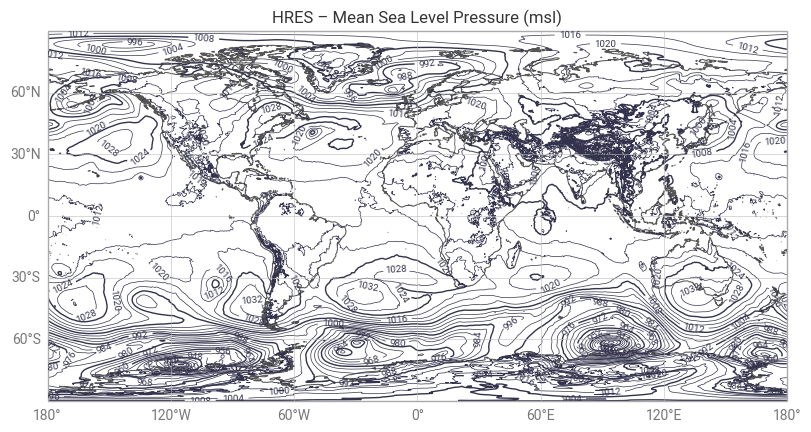

In [24]:
import earthkit.data as ekd
import earthkit.plots as ekp

hres = ekd.from_source("file", "data/hres_msl.grib2")
hres_field = hres.sel(shortName="msl")[0]

chart = ekp.Map(domain="global")
chart.contour(hres_field, units="hPa", auto_style=True)
chart.coastlines()
chart.gridlines()
chart.title("HRES – Mean Sea Level Pressure (msl)")
chart.show()


2. ENS – 2m Temperature

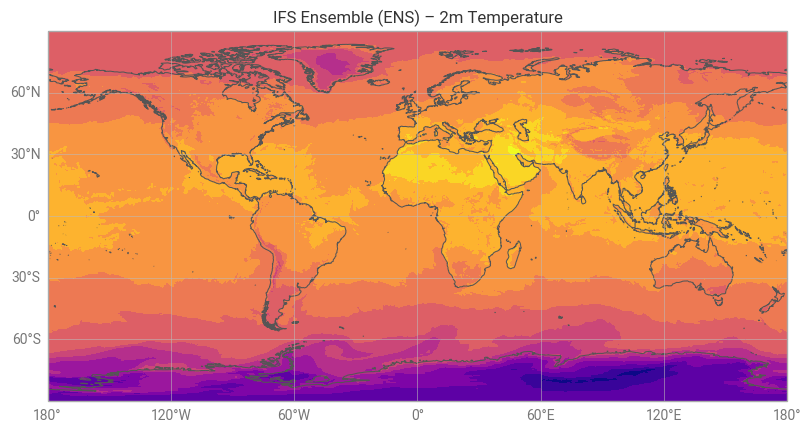

In [35]:
ens_field = ens.sel(shortName="2t")[0]

chart = ekp.Map(domain="global")
chart.contourf(ens_field, style=ekp.styles.Style(units="K"))
chart.coastlines()
chart.gridlines()
chart.title("IFS Ensemble (ENS) – 2m Temperature")
chart.show()


3. AIFS Deterministic – MSLP

ECCODES WARNING :  Key gridSpec is not yet implemented. Work in progress...


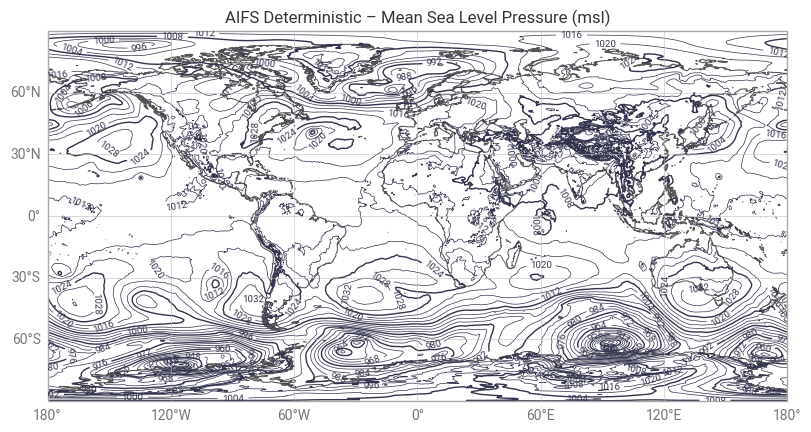

In [26]:
aifs = ekd.from_source("file", "data/aifs_det_msl.grib2")
aifs_field = aifs.sel(shortName="msl")[0]

chart = ekp.Map(domain="global")
chart.contour(aifs_field, units="hPa", auto_style=True)
chart.coastlines()
chart.gridlines()
chart.title("AIFS Deterministic – Mean Sea Level Pressure (msl)")
chart.show()


4. AIFS Ensemble – 2m Temperature

ECCODES WARNING :  Key gridSpec is not yet implemented. Work in progress...


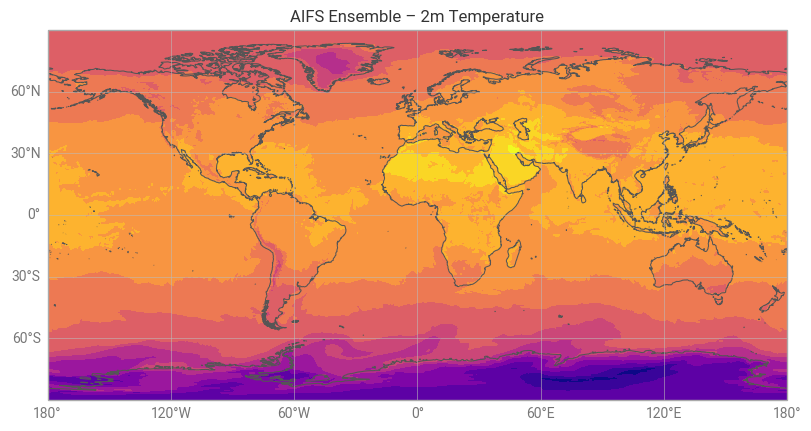

In [27]:
aifs_ens = ekd.from_source("file", "data/aifs_ens_2t.grib2")
aifs_ens_field = aifs_ens.sel(shortName="2t")[0]

chart = ekp.Map(domain="global")
chart.contourf(aifs_ens_field, style=ekp.styles.Style(units="K"))
chart.coastlines()
chart.gridlines()
chart.title("AIFS Ensemble – 2m Temperature")
chart.show()

5. Wave Model – Significant Wave Height

ECCODES WARNING :  Key gridSpec is not yet implemented. Work in progress...


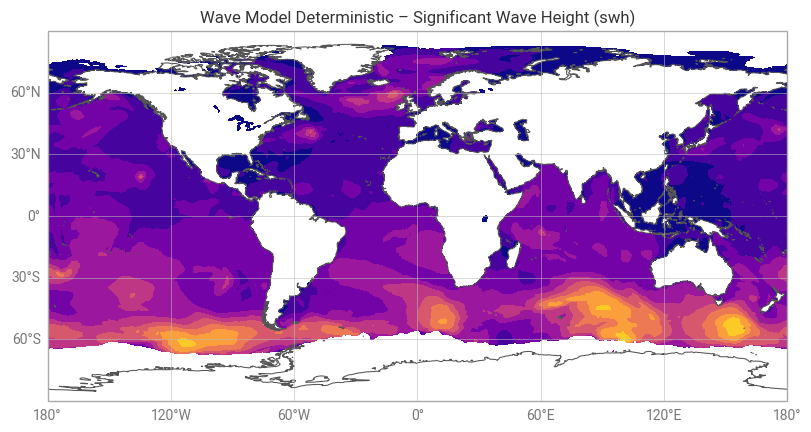

In [28]:
wave = ekd.from_source("file", "data/wave_deterministic_swh.grib2")
wave_field = wave.sel(shortName="swh")[0]

chart = ekp.Map(domain="global")
chart.contourf(wave_field, style=ekp.styles.Style(units="m"))
chart.coastlines()
chart.gridlines()
chart.title("Wave Model Deterministic – Significant Wave Height (swh)")
chart.show()


6. Wave Ensemble – Mean Wave Period

ECCODES WARNING :  Key gridSpec is not yet implemented. Work in progress...


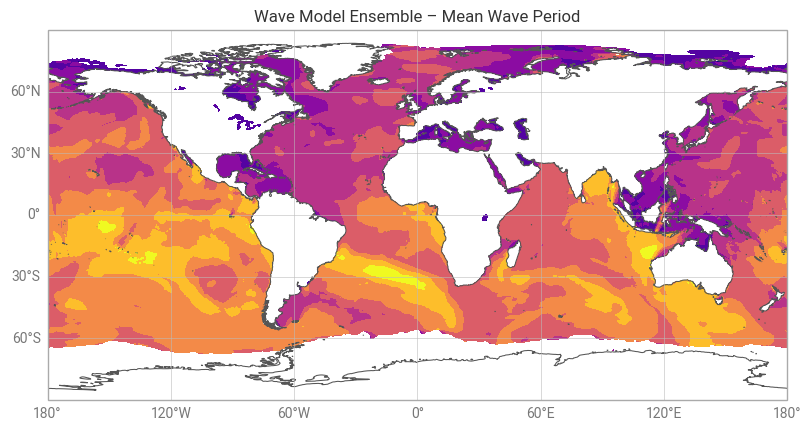

In [29]:
wave_ens = ekd.from_source("file", "data/wave_ensemble_mwp.grib2")
wave_ens_field = wave_ens.sel(shortName="mwp")[0]

chart = ekp.Map(domain="global")
chart.contourf(wave_ens_field, style=ekp.styles.Style(units="s"))
chart.coastlines()
chart.gridlines()
chart.title("Wave Model Ensemble – Mean Wave Period")
chart.show()


## 4. Other Plot Types (coming up)
We will show 1–2 examples of:
- `ekp.quickplot`
- `ekp.Line`
- `ekp.Barbs`, `ekp.Hovmoller`


### Example: Wind Vectors with EarthKit

We demonstrate two different ways to visualize 10m wind using EarthKit’s plotting API:

1. **Basic wind barbs**, useful for directional vector display.
2. **Styled wind quiver plot**, where arrow color represents wind speed.

These plots are created using the `Map` chart type and built-in `.barbs()` or `.quiver()` methods from EarthKit.

In [37]:
client.retrieve(
    model="ifs",
    stream="oper",
    type="fc",
    time=fc_time,
    date=fc_date,
    step=0,
    param="10u/10v",
    target="data/hres_uv.grib2"
)


20250807120000-0h-oper-fc.grib2:   0%|          | 0.00/1.65M [00:00<?, ?B/s]

Wind Speed + Barbs

ECCODES WARNING :  Key gridSpec is not yet implemented. Work in progress...
ECCODES WARNING :  Key gridSpec is not yet implemented. Work in progress...


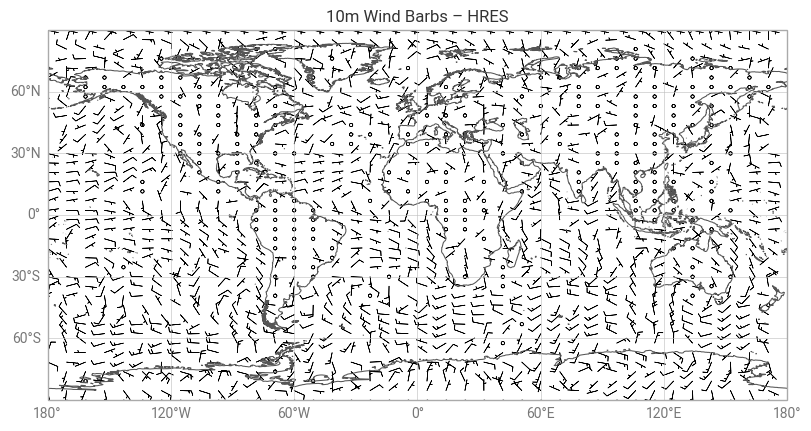

In [45]:
import earthkit.data as ekd
import earthkit.plots as ekp

# Load u10 and v10 wind components
ds = ekd.from_source("file", "data/hres_uv.grib2")
u10 = ds.sel(shortName="10u")[0]
v10 = ds.sel(shortName="10v")[0]

# Create chart
chart = ekp.Map(domain="global")

# Add wind barbs (default style)
chart.barbs(u10, v10)

# Add extras
chart.coastlines()
chart.gridlines()
chart.title("10m Wind Barbs – HRES")
chart.show()


In [ ]:
# # --- Simple wind barbs with EarthKit (fixed) ---
# import earthkit.data as ekd
# import earthkit.plots as ekp
# from earthkit.plots.resample import Subsample  # <-- key change


# ds  = ekd.from_source("file", "data/hres_uv.grib2")
# u10 = ds.sel(shortName="10u")[0]
# v10 = ds.sel(shortName="10v")[0]

# chart = ekd.plots.Map(domain=[-20, 5, 40, 60])

# style = ekd.plots.styles.Style(
#     colors="plasma_r",
#     levels=range(0, 22, 2),
#     units="m s-1",
# )

# chart.quiver(ds, style=style)

# chart.legend(label="wind speed ({units})", location="right")

# chart.land()
# chart.coastlines()
# chart.gridlines()
# chart.show()


import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import earthkit.data as ekd
import earthkit.plots as ekp

# Load wind components you already downloaded
ds  = ekd.from_source("file", "data/hres_uv.grib2")
u10 = ds.sel(shortName="10u")[0].to_xarray()
v10 = ds.sel(shortName="10v")[0].to_xarray()

# Coordinates + values
lats = u10.latitude.values
lons = u10.longitude.values
U = u10.values
V = v10.values
speed = np.hypot(U, V)

# Thin vectors so it’s readable
stride = 10
lats_ds = lats[::stride]
lons_ds = lons[::stride]
U_ds = U[::stride, ::stride]
V_ds = V[::stride, ::stride]
S_ds = speed[::stride, ::stride]
lon_grid, lat_grid = np.meshgrid(lons_ds, lats_ds)

# EarthKit map
chart = ekp.Map(domain="global")

# Draw colored vectors with Matplotlib on the EarthKit axes
q = chart.ax.quiver(
    lon_grid, lat_grid, U_ds, V_ds, S_ds,
    transform=ccrs.PlateCarree(),
    cmap="plasma",
    scale=300,      # tweak: smaller -> longer arrows
    width=0.002
)

# Extras
chart.coastlines()
chart.gridlines()
chart.title("10 m Wind Vectors – HRES (colored by speed)")

# Colorbar
cb = plt.colorbar(q, ax=chart.ax, orientation="vertical", pad=0.02)
cb.set_label("Wind speed (m s⁻¹)")

chart.show()



TimeSeriesPlot (for 1D data like pressure at a point)

In [50]:
# coming up


LinePlot (e.g. temperature profile vs. height or index)

In [51]:
# coming up


## 5. Derived Parameters and Calculations (coming up, possibly also in Expert JN)
Example topics may include:
- CAPE, CIN, or anomalies
- compare datasets (aifs/ifs)
	- multiple sources (seasonal + deterministic)
		- c3s
		- s2s
		- combine 15day and 48 hr data (ACMAD use case)
	- derived params from ecmwf and combined data
		- EFI
		- others?
- Open data notebooks combining with EUM data (MTG,Metop-SG)
- Use case notebooks for events in Africa
